### [05/02/22] CIFAR10 ResNet20 Successive IMP Optima LMC

In [1]:
from composer.datasets import DataLoaderHparams
from composer.utils.object_store import ObjectStoreProviderHparams
from copy import deepcopy
from lth_diet.data import CIFAR10DataHparams
from lth_diet.exps import LotteryExperiment
from lth_diet.models import ResNetCIFARClassifierHparams
from lth_diet.pruning import Mask, PrunedClassifier
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import torch
from tqdm import tqdm
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 11, "axes.titlesize": 11, "xtick.labelsize": 10, "ytick.labelsize": 10,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, 'lines.markeredgecolor': 'w', "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("tab10"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = os.environ['OBJECT_STORE_DIR']

In [2]:
torch.set_grad_enabled(False)

In [3]:
config = f"../configs/lottery_test.yaml"
exp = LotteryExperiment.create(f=config, cli_args=False)
print(exp.name)

Lottery(model=ResNetCIFAR(num_classes=10,num_layers=20),train_data=CIFAR10(train=True),train_batch_size=128,optimizer=SGDHparams(lr=0.1,momentum=0.9,weight_decay=0.0001,dampening=0.0,nesterov=False),schedulers=[MultiStepSchedulerHparams(milestones=[31200ba,46800ba],gamma=0.1)],max_duration=62400ba,seed=6174,rewinding_steps=0ba,pruning=PruningHparams(pruning_fraction=0.2),algorithms=[ChannelsLastHparams()],callbacks=[LRMonitorHparams()])


In [4]:
rewinding_steps = np.array([0, 100, 250, 500, 1000, 2000])
replicates = np.arange(4)
levels = np.arange(15)
data = CIFAR10DataHparams(False).initialize_object(1000, DataLoaderHparams(persistent_workers=False))
model_hparams = ResNetCIFARClassifierHparams(10, 20)

In [5]:
def load_model(exp, replicate, level, object_store, model_hparams, init=False):
    location = os.path.join(utils.get_hash(exp.name), f"replicate_{replicate}", f"level_{level}", "main")
    name = "model_init.pt" if init else "model_final.pt"
    state_dict = utils.load_object(location, name, object_store, torch.load)
    mask = Mask.load(location, object_store)
    model = model_hparams.initialize_object()
    model.module.load_state_dict(state_dict)
    model = PrunedClassifier(model, mask)
    return model

def get_test_acc(model, data):
    model.cuda()
    model.eval()
    correct = 0
    for batch in data:
        batch = batch[0].cuda(), batch[1].cuda()
        logits = model(batch)
        correct += (logits.argmax(dim=-1) == batch[1]).sum()
    return correct / len(data.dataset)

def midpoint(state_dict, state_dict_):
    state_dict__ = {}
    for k, v in state_dict.items():
        state_dict__[k] = (v + state_dict_[k]) / 2
    return state_dict__

In [6]:
# accs_srl = []
# for rs in rewinding_steps:
#     exp.rewinding_steps = f"{rs}ba"
#     accs_rl = []
#     for rep in tqdm(replicates):
#         accs_l = []
#         for lvl in levels:
#             # k
#             model = load_model(exp, rep, lvl, object_store, model_hparams, init=False)
#             accs_l.append(get_test_acc(model, data))
#             # k, k+1
#             model_ = load_model(exp, rep, lvl+1, object_store, model_hparams, init=False)
#             model_.cuda()
#             state_dict = midpoint(model.module.state_dict(), model_.module.state_dict())
#             model.module.load_state_dict(state_dict)  # load state_dict to model k because it has the right mask
#             model._apply_mask()  # apply model k mask
#             accs_l.append(get_test_acc(model, data))
#         accs_l.append(get_test_acc(model_, data))
#         accs_rl.append(accs_l)
#     accs_srl.append(accs_rl)
# accs_srl = torch.tensor(accs_srl).numpy()
# errs_final_slr = deepcopy(1 - accs_srl.transpose(0, 2, 1))

In [7]:
errs_final_slr = np.load("temp/errs_final_slr.npy")

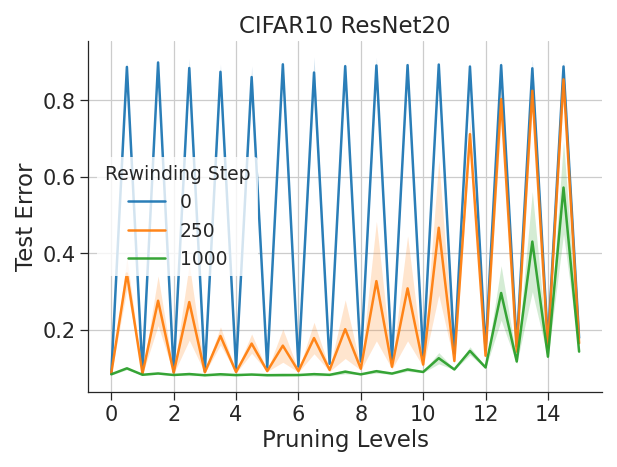

In [8]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
for i in range(errs_final_slr.shape[0]):
    if i in [0, 2, 4]:
        x, ys = np.arange(errs_final_slr.shape[1])/2, errs_final_slr[i]
        ym, ye = ys.mean(-1), ys.std(-1)
        ax.plot(x, ym, alpha=0.95, label=rewinding_steps[i])
        ax.fill_between(x, ym-ye, ym+ye, alpha=0.2)
ax.legend(fontsize=9, title="Rewinding Step", title_fontsize=9, loc=6)
plt.xticks(np.arange(8)*2)
ax.set_xlabel("Pruning Levels")
ax.set_ylabel("Test Error")
ax.set_title("CIFAR10 ResNet20")
fig.show()

In [9]:
train_data = CIFAR10DataHparams(True, no_augment=True).initialize_object(1000, DataLoaderHparams(persistent_workers=False))

In [10]:
def get_train_loss(model, data):
    model.cuda()
    model.eval()
    loss = 0
    for batch in data:
        batch = batch[0].cuda(), batch[1].cuda()
        logits = model(batch)
        loss += model.loss(logits, batch) * batch[0].shape[0]
    return loss / len(data.dataset)

In [11]:
loss_srl = []
for rs in rewinding_steps:
    exp.rewinding_steps = f"{rs}ba"
    loss_rl = []
    for rep in tqdm(replicates):
        loss_l = []
        for lvl in levels:
            # k
            model = load_model(exp, rep, lvl, object_store, model_hparams, init=True)
            loss_l.append(get_train_loss(model, train_data))
            # k, k+1
            model_ = load_model(exp, rep, lvl+1, object_store, model_hparams, init=True)
            model_.cuda()
            state_dict = midpoint(model.module.state_dict(), model_.module.state_dict())
            model.module.load_state_dict(state_dict)  # load state_dict to model k because it has the right mask
            model._apply_mask()  # apply model k mask
            loss_l.append(get_train_loss(model, train_data))
        loss_l.append(get_train_loss(model_, train_data))
        loss_rl.append(loss_l)
    loss_srl.append(loss_rl)
loss_srl = torch.tensor(loss_srl).numpy()
loss_init_slr = deepcopy(loss_srl.transpose(0, 2, 1))

100%|██████████| 4/4 [08:29<00:00, 127.33s/it]


In [ ]:
np.save("temp/loss_init_slr.npy", loss_init_slr)

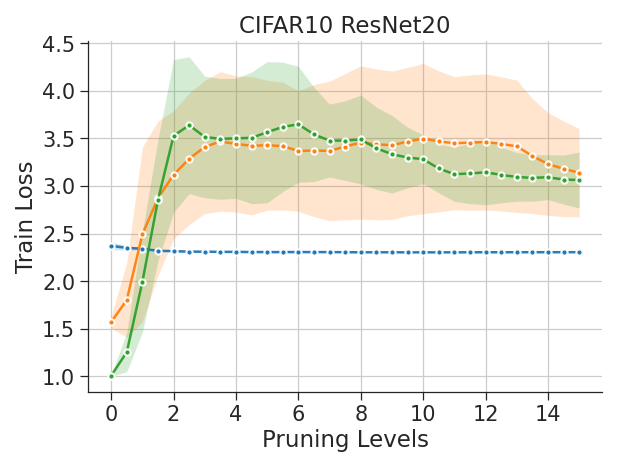

In [18]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
for i in range(loss_init_slr.shape[0]):
    if i in [0, 2, 4]:
        x, ys = np.arange(loss_init_slr.shape[1])/2, loss_init_slr[i]
        ym, ye = ys.mean(-1), ys.std(-1)
        ax.plot(x, ym, '.-', alpha=0.95, label=rewinding_steps[i])
        ax.fill_between(x, ym-ye, ym+ye, alpha=0.2)
# ax.legend(fontsize=9, title="Rewinding Step", title_fontsize=9, loc=6)
plt.xticks(np.arange(8)*2)
ax.set_xlabel("Pruning Levels")
ax.set_ylabel("Train Loss")
ax.set_title("CIFAR10 ResNet20")
fig.show()